Objective :  To develop a deep learning model (Neural Network) that detects 
fraudulent transactions based on the historical transactional data of customers with a pool of 
merchants and provide a cost benefit analysis of the model to the stakeholders and provide them 
with appropriate recommendations to adopt in order to mitigate fraud risks.


# Import Necessary Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Read the file

In [73]:
from google.colab import files 
uploaded = files.upload()


Saving Data2.csv to Data2 (1).csv


In [74]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Data2.csv']))

In [75]:
data.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,944503,2020-01-12 16:49:00,345832460465610,fraud_Ebert-Daugherty,travel,9.90,Jason,Mcmahon,M,6385 Donald Square Suite 429,...,38.8029,-77.2116,104396,Production engineer,1950-11-20,c76bdd4f15a7d8c0a77c5f7b4f9e309c,1358009340,38.994651,-77.918027,0
1,961287,2020-01-22 07:25:57,2720830304681674,"fraud_Lockman, West and Runte",grocery_pos,189.42,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,...,36.5220,-87.3490,151785,Pathologist,1974-03-28,fddb83d41fa54e0a2c311658ed09feb8,1358839557,36.318767,-86.625794,0
2,864263,2019-12-18 16:00:01,4601636330889,fraud_Stamm-Witting,shopping_net,991.74,Mark,Rivera,M,383 Contreras Hills Suite 658,...,30.0041,-95.2825,194500,Tax adviser,1990-12-18,1e58692eb56a749356b43e0378a250b5,1355846401,29.127633,-94.545702,1


In [76]:
data.shape

(12009, 23)

# Check the data types of the columns

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12009 entries, 0 to 12008
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             12009 non-null  int64  
 1   trans_date_trans_time  12009 non-null  object 
 2   cc_num                 12009 non-null  int64  
 3   merchant               12009 non-null  object 
 4   category               12009 non-null  object 
 5   amt                    12009 non-null  float64
 6   first                  12009 non-null  object 
 7   last                   12009 non-null  object 
 8   gender                 12009 non-null  object 
 9   street                 12009 non-null  object 
 10  city                   12009 non-null  object 
 11  state                  12009 non-null  object 
 12  zip                    12009 non-null  int64  
 13  lat                    12009 non-null  float64
 14  long                   12009 non-null  float64
 15  ci

# Check for Missing values

In [78]:
data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Inspect the target variable distribution

In [79]:
data['is_fraud'].value_counts()
# 1 = Fraud
# 0 = Not Fraud

0    6010
1    5999
Name: is_fraud, dtype: int64

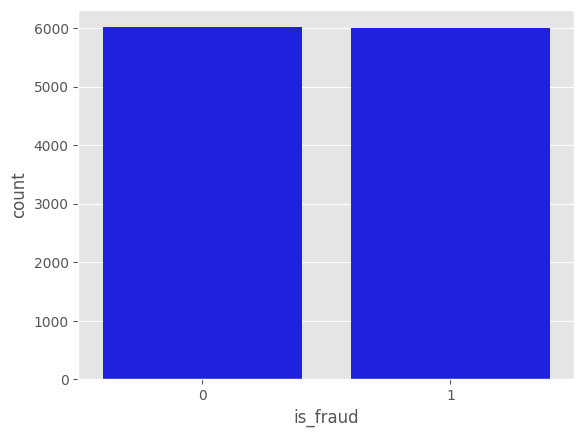

In [80]:
plt.figure()
sns.countplot(data = data, x = 'is_fraud',color = 'blue')
plt.show()

# Check for duplicated records

In [81]:
data.duplicated().sum()

0

# Convert the data types of necessary columns

In [82]:
data['trans_date_trans_time'] = pd.to_datetime(
                                data['trans_date_trans_time']
                                              )
data['dob'] = pd.to_datetime(data['dob'])

In [83]:
data.dtypes

Unnamed: 0                        int64
trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
dtype: object

In [84]:
categorical_cols = data.select_dtypes(include = 'object').columns

for col in categorical_cols:
    data[col] = data[col].str.lower().str.strip()

data[categorical_cols].nunique().sort_values()

gender           2
category        14
state           51
first          352
last           480
job            493
merchant       693
city           889
street         977
trans_num    12009
dtype: int64

# Drop some columns which are not required and cannot be grouped

In [85]:
drop_cols_1 = ['Unnamed: 0','street','merchant','zip','first','last','trans_num']
data.drop(drop_cols_1, axis = 1, inplace = True)
list(data.columns)

['trans_date_trans_time',
 'cc_num',
 'category',
 'amt',
 'gender',
 'city',
 'state',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

# Extract transaction hour, month, day name from 'trans_date_trans_time' column.

In [86]:
data['transaction_hour'] = data['trans_date_trans_time'].dt.hour
print(data['transaction_hour'].unique())

data['transaction_month'] = data['trans_date_trans_time'].dt.month
print(data['transaction_month'].unique())

data['transaction_DayofWeek'] = data['trans_date_trans_time'].dt.day_name()
print(data['transaction_DayofWeek'].unique())

[16  7  2 13  0 18  1 21 11 22 23 10  3 14  5 12 15 19 17  9  8 20  6  4]
[ 1 12 11  8  7  3  6  2  4  5 10  9]
['Sunday' 'Wednesday' 'Thursday' 'Tuesday' 'Monday' 'Saturday' 'Friday']


In [87]:
data.groupby('cc_num')['cc_num'].count().sort_values(ascending = False).describe().astype('int')

count    977
mean      12
std        5
min        1
25%        8
50%       12
75%       16
max       30
Name: cc_num, dtype: int64

# We need to find the delay between previous transaction and current transaction as multiple transactions are carried out by single credit card on an average 12.

# 1. sort the dataframe on transaction datetime and cc_num

In [88]:
data.sort_values(by = ['cc_num','unix_time'], ascending = True, inplace = True)
data.head(20)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud,transaction_hour,transaction_month,transaction_DayofWeek
1446,2019-03-01 02:42:25,60416207185,gas_transport,11.74,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330569745,42.656763,-109.868240,1,2,3,Friday
9273,2019-03-01 23:06:58,60416207185,personal_care,19.16,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330643218,42.084862,-109.537321,1,23,3,Friday
9490,2019-03-02 22:10:38,60416207185,shopping_pos,830.06,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330726238,42.739276,-107.975363,1,22,3,Saturday
7261,2019-03-02 22:10:59,60416207185,home,261.79,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330726259,42.204230,-109.341230,1,22,3,Saturday
2876,2019-03-02 23:08:08,60416207185,food_dining,130.08,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330729688,42.869714,-108.879962,1,23,3,Saturday
10786,2019-03-02 23:11:08,60416207185,personal_care,20.41,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330729868,42.132393,-109.694820,1,23,3,Saturday
11315,2019-03-02 23:43:40,60416207185,kids_pets,19.23,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1330731820,42.995377,-109.128294,1,23,3,Saturday
8859,2019-06-18 18:34:47,60416207185,shopping_pos,6.04,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1340044487,42.696537,-109.459253,0,18,6,Tuesday
11789,2019-07-23 04:05:59,60416207185,gas_transport,57.39,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1343016359,43.985519,-109.123418,0,4,7,Tuesday
1883,2019-09-07 17:29:16,60416207185,kids_pets,51.00,f,fort washakie,wy,43.0048,-108.8964,1645,information systems manager,1986-02-17,1347038956,42.914771,-109.801937,0,17,9,Saturday


# unix_time for the previous transactions using the shift method in pandas

In [89]:

data['unix_time_prev_transaction'] = data.groupby('cc_num')['unix_time'].shift(1)
data['unix_time_prev_transaction'].head(5)

1446             NaN
9273    1.330570e+09
9490    1.330643e+09
7261    1.330726e+09
2876    1.330726e+09
Name: unix_time_prev_transaction, dtype: float64

In [90]:
data.isnull().sum()

trans_date_trans_time           0
cc_num                          0
category                        0
amt                             0
gender                          0
city                            0
state                           0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
transaction_hour                0
transaction_month               0
transaction_DayofWeek           0
unix_time_prev_transaction    977
dtype: int64

# For all the rows with null values, we are filling with = current unix time value - 86400 (Number of seconds in a day)

In [91]:
data['unix_time_prev_transaction'].fillna(data['unix_time'] - 86400, inplace = True)

In [92]:
data['unix_time_prev_transaction'].head(5)

1446    1.330483e+09
9273    1.330570e+09
9490    1.330643e+09
7261    1.330726e+09
2876    1.330726e+09
Name: unix_time_prev_transaction, dtype: float64

# Time delay between the previous and current transaction - Converting into mins

In [93]:
data['time_delay'] = (data['unix_time'] - data['unix_time_prev_transaction'])//60

In [94]:
data['time_delay'].head(5)

1446    1440.0
9273    1224.0
9490    1383.0
7261       0.0
2876      57.0
Name: time_delay, dtype: float64

# Now we will look at the DOB

In [95]:
data['Age'] = (data['trans_date_trans_time'] - data['dob']).astype('timedelta64[Y]')
data['Age'].head(5)

1446    33.0
9273    33.0
9490    33.0
7261    33.0
2876    33.0
Name: Age, dtype: float64

# Now let's calculate the distances

# 1. Latitude distance between Customer location and current Merchant location

In [96]:
data['lat_dist_cust_merch'] = (data['lat'] - data['merch_lat']).abs()
data['lat_dist_cust_merch'].head(3)

1446    0.348037
9273    0.919938
9490    0.265524
Name: lat_dist_cust_merch, dtype: float64

# 2. Longitude distance between Customer location and current Merchant location

In [97]:
data['long_dist_cust_merch'] = (data['long'] - data['merch_long']).abs()
data['long_dist_cust_merch'].head(3)

1446    0.971840
9273    0.640921
9490    0.921037
Name: long_dist_cust_merch, dtype: float64

# 3. Latitude distance between the Current merchant location and previous Merchant location

# first get the latitude values of the previous merchant

In [98]:
data['prev_merch_lat'] = data.groupby('cc_num')['merch_lat'].shift(1)
print(data['prev_merch_lat'].head(3))

data['prev_merch_lat'].fillna(data['merch_lat'],inplace = True)
print(data['prev_merch_lat'].head(3))

1446          NaN
9273    42.656763
9490    42.084862
Name: prev_merch_lat, dtype: float64
1446    42.656763
9273    42.656763
9490    42.084862
Name: prev_merch_lat, dtype: float64


In [99]:
# Distance

data['lat_dist_prev_curr_merch'] = (data['merch_lat'] - data['prev_merch_lat']).abs()
print(data['lat_dist_prev_curr_merch'].head(3))

1446    0.000000
9273    0.571901
9490    0.654414
Name: lat_dist_prev_curr_merch, dtype: float64


# 4. Longitude distance between the Current merchant location and previous Merchant location

# first get the longitude values of the previous merchant

In [100]:
data['prev_merch_long'] = data.groupby('cc_num')['merch_long'].shift(1)
print(data['prev_merch_long'].head(3))

data['prev_merch_long'].fillna(data['merch_long'],inplace = True)
print(data['prev_merch_long'].head(3))

1446           NaN
9273   -109.868240
9490   -109.537321
Name: prev_merch_long, dtype: float64
1446   -109.868240
9273   -109.868240
9490   -109.537321
Name: prev_merch_long, dtype: float64


In [101]:
# Distance

data['long_dist_prev_curr_merch'] = (data['merch_long'] - data['prev_merch_long']).abs()
print(data['long_dist_prev_curr_merch'].head(3))

1446    0.000000
9273    0.330919
9490    1.561958
Name: long_dist_prev_curr_merch, dtype: float64


In [102]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'gender', 'city',
       'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour',
       'transaction_month', 'transaction_DayofWeek',
       'unix_time_prev_transaction', 'time_delay', 'Age',
       'lat_dist_cust_merch', 'long_dist_cust_merch', 'prev_merch_lat',
       'lat_dist_prev_curr_merch', 'prev_merch_long',
       'long_dist_prev_curr_merch'],
      dtype='object')

# List of the columns to be dropped


In [103]:
drop_col_2 = ['trans_date_trans_time','cc_num','unix_time',
              'unix_time_prev_transaction','dob','job',
              'lat','long','merch_lat','merch_long',
              'prev_merch_lat','prev_merch_long','city']

In [104]:
data.drop(drop_col_2, axis = 1, inplace = True)
data.reset_index(drop = True, inplace = True)
list(data.columns)

['category',
 'amt',
 'gender',
 'state',
 'city_pop',
 'is_fraud',
 'transaction_hour',
 'transaction_month',
 'transaction_DayofWeek',
 'time_delay',
 'Age',
 'lat_dist_cust_merch',
 'long_dist_cust_merch',
 'lat_dist_prev_curr_merch',
 'long_dist_prev_curr_merch']

In [105]:
data.shape

(12009, 15)

Variable Analysis and Visualization
1.Create seperate dataframes for fraud and normal transactions for ease of exploration
2.Create functions for reusability

In [106]:
total_transactions = data.copy()

print(type(total_transactions))

total_transactions['class'] = total_transactions['is_fraud'].map({1:'Fraud', 0:'Non_fraud'})

Normal = total_transactions[data['is_fraud'] == 0]

print(type(Normal))
# print(Normal.head(1))

Fraud = total_transactions[data['is_fraud'] == 1]

print(type(Fraud))
# print(Fraud.head(1))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Function to show simple statistics by class

In [107]:
def stats_by_class(variable):
    stat_grid = total_transactions.groupby('class')[variable].agg([np.min, np.max, np.mean, np.median])
    stat_grid = stat_grid.transpose().round(2)
    return stat_grid

# Function to show simple statistics by variable

In [108]:
def stats_by_var(variable):
    n = (Normal[variable].value_counts(normalize = True)*100).round(2).rename('Normal')
    f = (Fraud[variable].value_counts(normalize = True)*100).round(2).rename('Fraud')
    return pd.concat([n,f], axis = 1).transpose()

# Function for plotting the boxplot


In [109]:
def plot_box (data, x, y, title , width = 10, height = 7):
    plt.figure(figsize = [width,height])
    sns.boxplot(data = data, x = x, y = y)
    plt.title(title);

In [110]:
def normalize_count_by_class(variable, width = 20, height = 7):
    plt.figure(figsize = [width, height])
    
    normalized_normal = (Normal.groupby('class')[variable].value_counts(normalize = True)*100).rename('value').reset_index()
    
    normalized_fraud = (Fraud.groupby('class')[variable].value_counts(normalize = True)*100).rename('value').reset_index()   
    
    plot_table = pd.concat([normalized_normal.set_index(variable)[['class','value']],
                           normalized_fraud.set_index(variable)[['class','value']]], axis = 0).reset_index()
    
    sns.barplot(data = plot_table, x = variable, y = 'value', hue = 'class')
    plt.title('\nNormalized frequency of the variable < '+variable+' > on both classes\n')
    plt.xticks(rotation = 30)
    
    summary_table = pd.concat([normalized_normal.set_index(variable)['value'],
                              normalized_fraud.set_index(variable)['value']],axis = 1).reset_index()
    summary_table.columns = [variable, 'normal', 'fraud']
    
    summary_table['diff in %'] = (summary_table['fraud'] - summary_table['normal'])
    
    summary_table.sort_values(by = 'diff in %', ascending  = True, inplace = True)
    
    del normalized_normal, normalized_fraud, plot_table
    
    print('\nNormalized frequency of < '+variable+' > on both classes and the % difference\n')

    return (summary_table)

In [111]:
plt.style.use('ggplot')

# is_fraud class distribution

Text(0.5, 1.0, 'Distribution of the target')

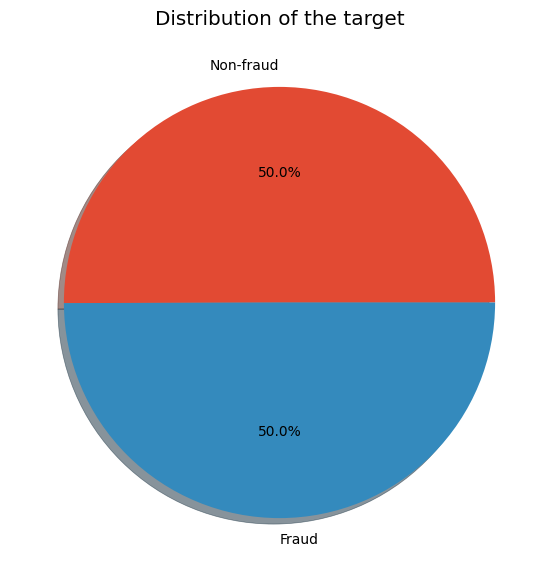

In [112]:
plt.figure(figsize = (7,7))
plot_var = total_transactions['is_fraud'].value_counts(normalize = True)
plt.pie(plot_var,
       autopct = '%1.1f%%',
       labels = ['Non-fraud','Fraud'],
       explode = [0,0],
       shadow = True 
       )
plt.title('Distribution of the target')

- Conclusion : Balanced dataset

# Gender of the card holder by class

,f,m
Normal,54.74,45.26
Fraud,50.11,49.89


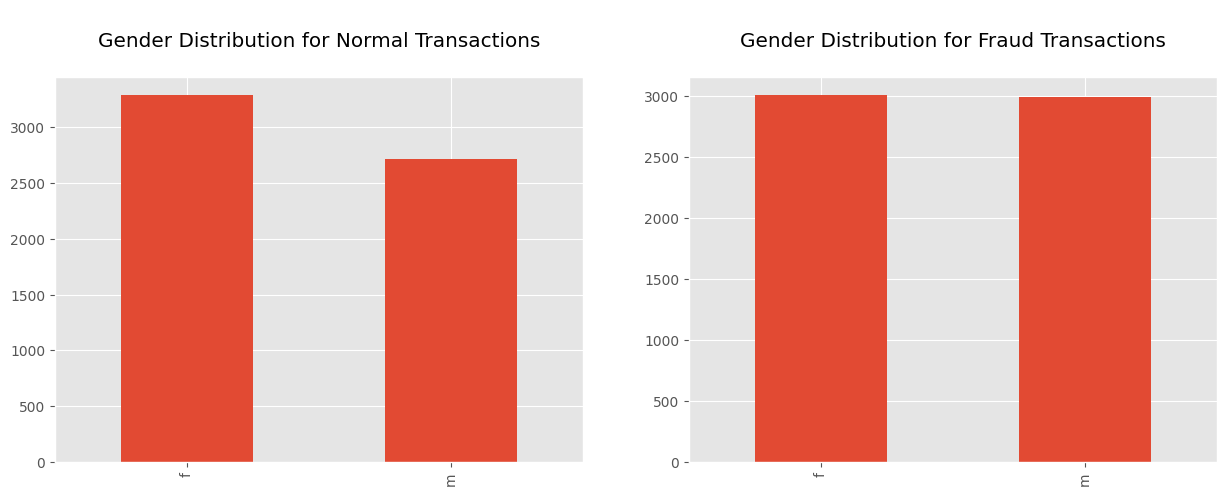

In [113]:

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
Normal['gender'].value_counts().plot(kind = 'bar')
plt.title('\nGender Distribution for Normal Transactions\n')

plt.subplot(1,2,2)
Fraud['gender'].value_counts().plot(kind = 'bar')
plt.title('\nGender Distribution for Fraud Transactions\n')

stats_by_var('gender')

- Conclusion : The fraud transactions are similarly distributed among male and female card holders

# Age of the card holder

class,Fraud,Non_fraud
amin,14.00,13.00
amax,93.00,95.00
mean,48.33,45.75
median,47.00,44.00


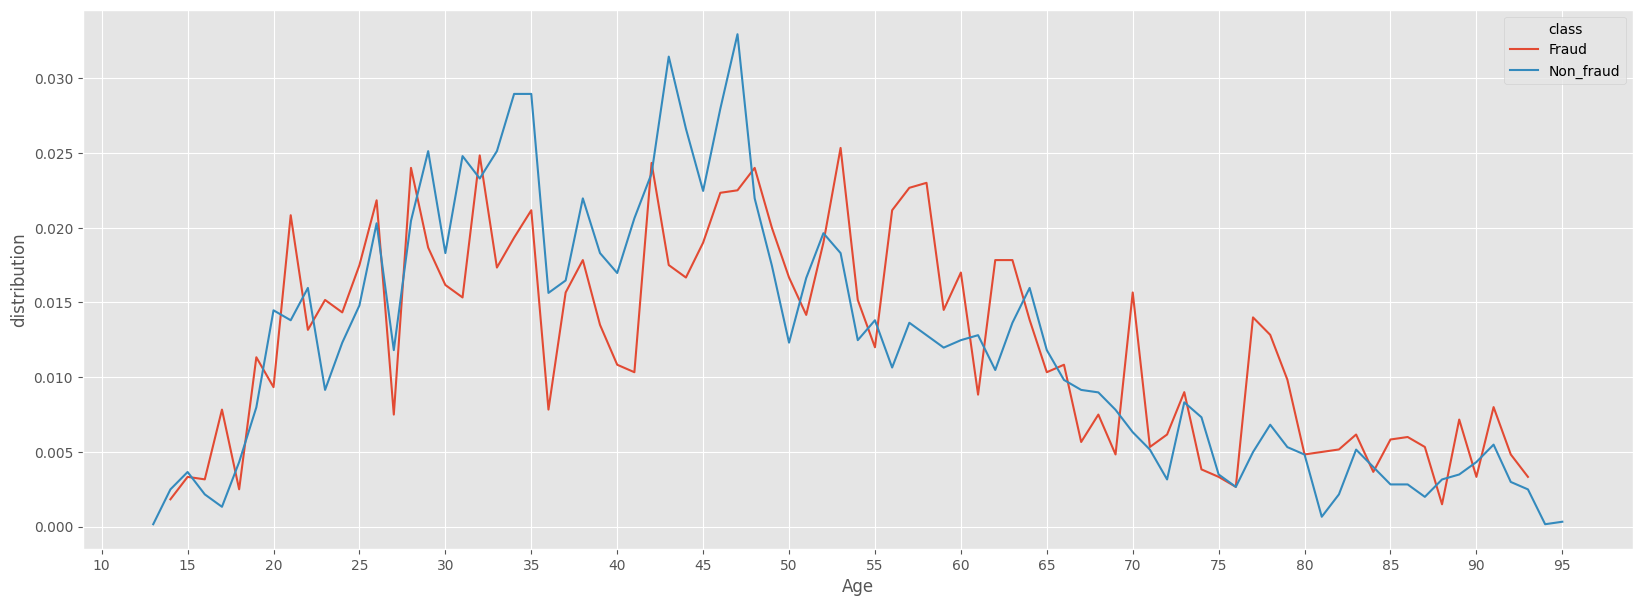

In [114]:
plt.figure(figsize = (20,7))

transaction_hour_distribution = total_transactions.groupby('class')['Age'].value_counts(normalize = True).rename('distribution').reset_index()

sns.lineplot(data = transaction_hour_distribution, x = 'Age', y = 'distribution', hue = 'class')

plt.xticks(np.arange(10,100,5))

stats_by_class('Age')


- Conclusion: We get the range of the Card holder's age associated with fraud transactions

# Amount of Transactions

class,Fraud,Non_fraud
amin,1.18,1.00
amax,1376.04,6337.25
mean,532.09,68.00
median,410.94,47.32


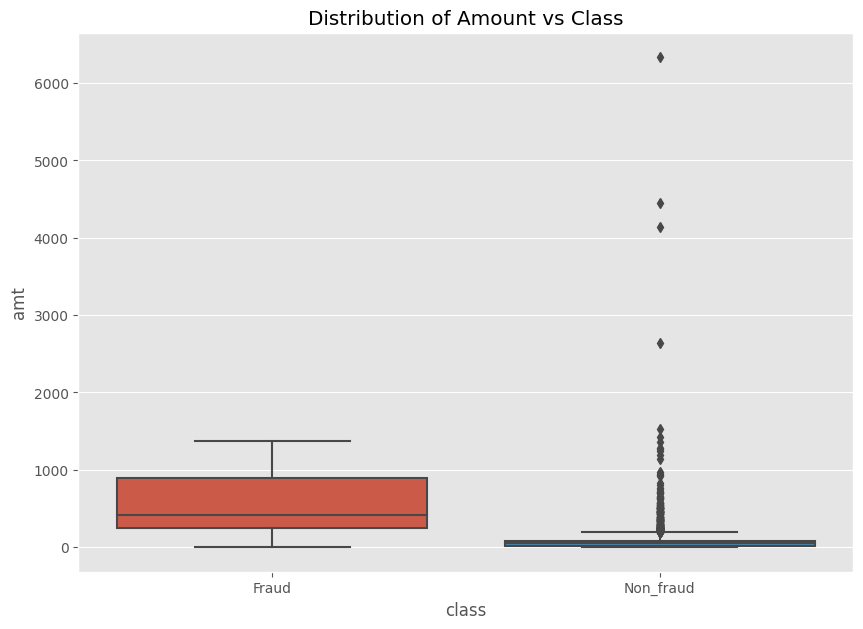

In [115]:
plot_box(total_transactions, 'class', 'amt','Distribution of Amount vs Class')

stats_by_class('amt')

- Conclusion: The mean value of the fraud transactions seems to be high. No outliers for fraud transactions.

# Hour of Transactions

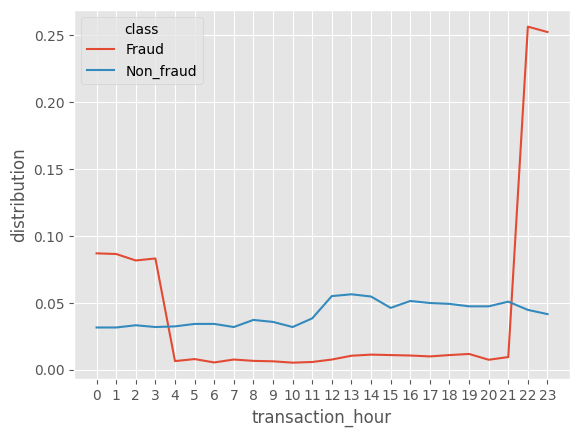

In [116]:
transactions_hour_distribution = total_transactions.groupby('class')['transaction_hour'].value_counts(normalize = True).rename('distribution').reset_index()

sns.lineplot(data = transactions_hour_distribution, x = 'transaction_hour', y = 'distribution', hue = 'class')
plt.xticks(np.arange(0,24,1))

plt.show()

- Conclusion:
1.Normal Transactions are distributed same
2.Fraud transactions are majorly taking place between 21st hour - 04 hour, in other words fraud transactions are happening during mid-night.

# Delay between each transactions

class,Fraud,Non_fraud
amin,0.00,25.00
amax,610942.00,705427.00
mean,9070.73,68231.19
median,127.00,41802.50


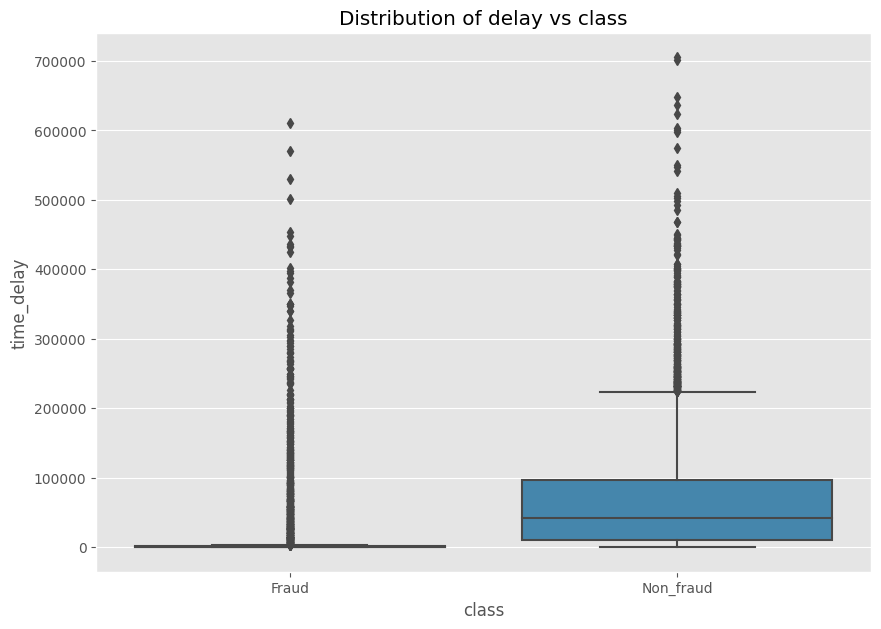

In [117]:
plot_box(total_transactions, 'class','time_delay','Distribution of delay vs class')

stats_by_class('time_delay')

- Conclusion: Successive fraud transactions are happening very quickly as compared to other transactions.

# The weekday of the transaction


Normalized frequency of < transaction_DayofWeek > on both classes and the % difference



,transaction_DayofWeek,normal,fraud,diff in %
0,Monday,19.101498,15.585931,-3.515567
1,Sunday,18.735441,16.219370,-2.516071
3,Tuesday,12.728785,12.735456,0.006671
2,Saturday,15.873544,16.336056,0.462512
6,Wednesday,10.465890,11.635273,1.169382
4,Friday,12.479201,14.119020,1.639819
5,Thursday,10.615641,13.368895,2.753254


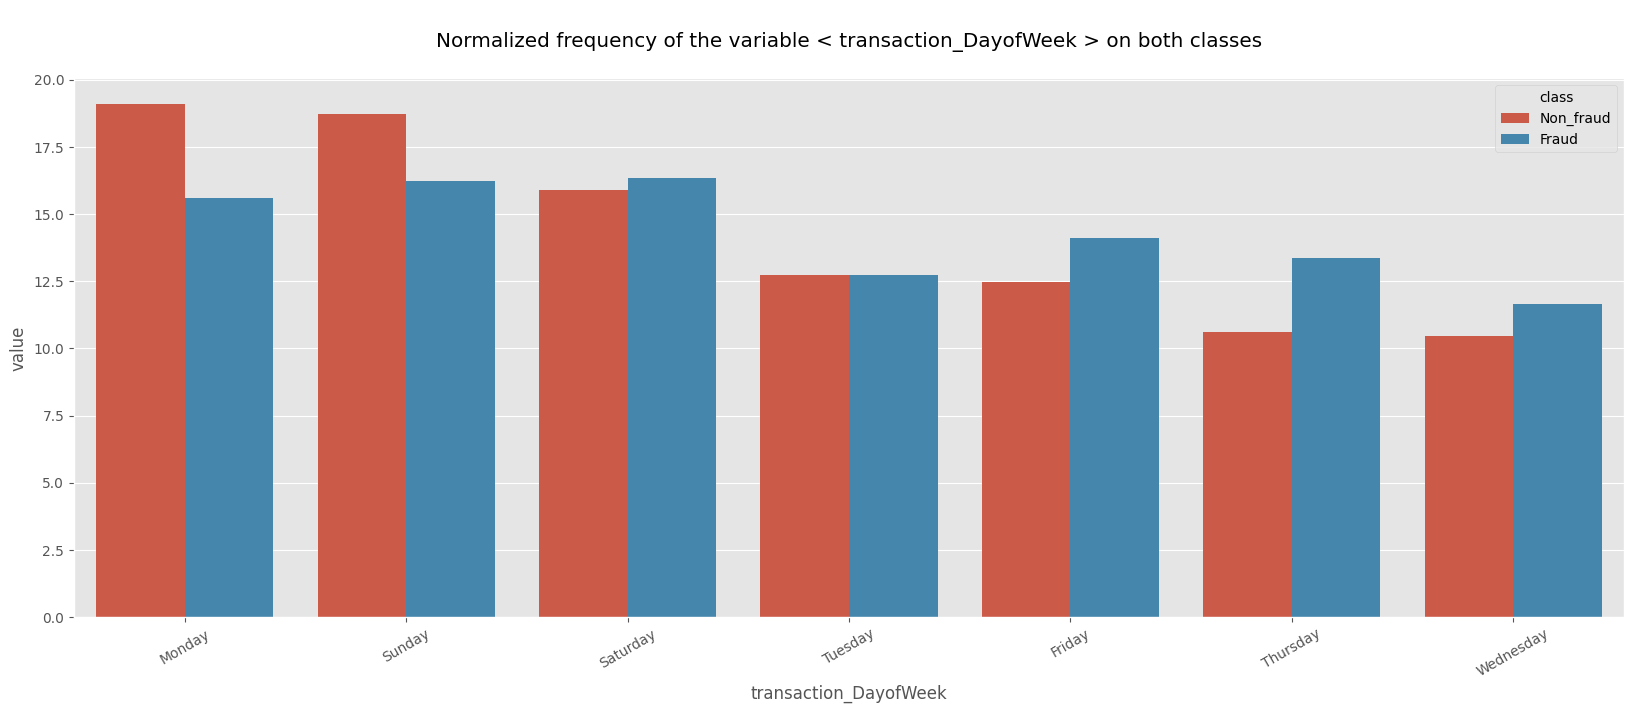

In [118]:
normalize_count_by_class('transaction_DayofWeek')

- Conclusion: The normalized % of the fraud transactions seems to be slight higher in thursday, friday, saturday, sunday

# Latitude distance between customer and merchant

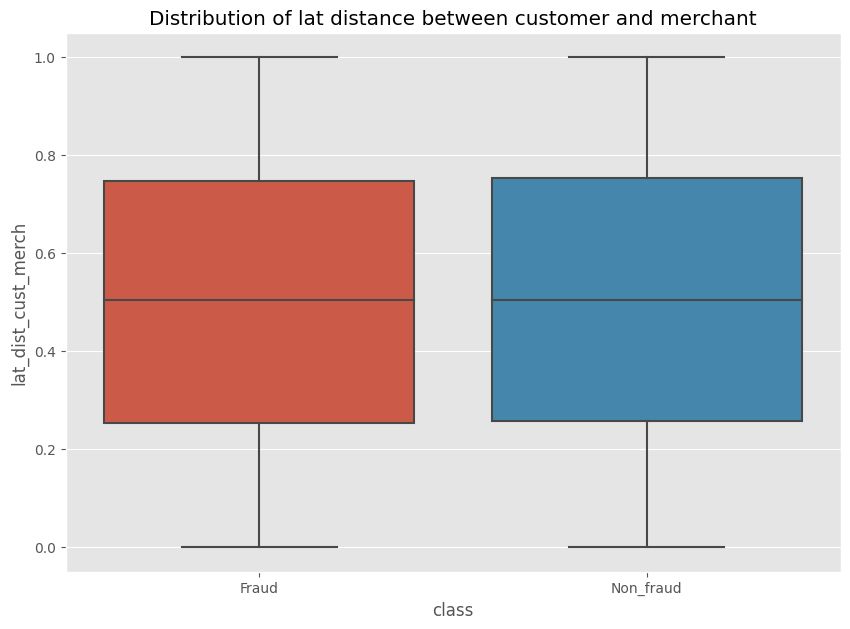

In [119]:
plot_box(total_transactions, 'class','lat_dist_cust_merch','Distribution of lat distance between customer and merchant')

- Conclusion: No observable difference

# Longitude distance between customer and merchant

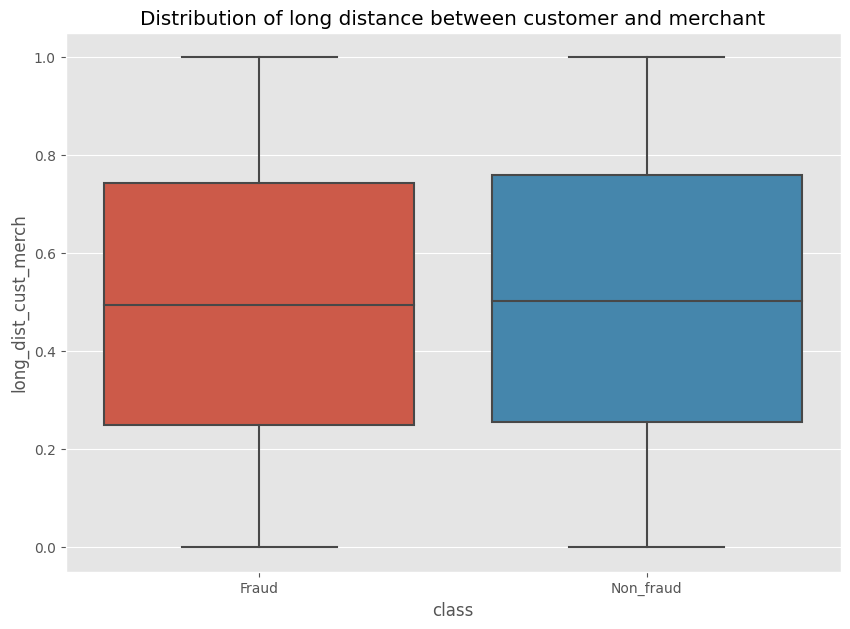

In [120]:
plot_box(total_transactions, 'class','long_dist_cust_merch','Distribution of long distance between customer and merchant')

- Conclusion: No observable difference

# Lat distance between previous and current merchant

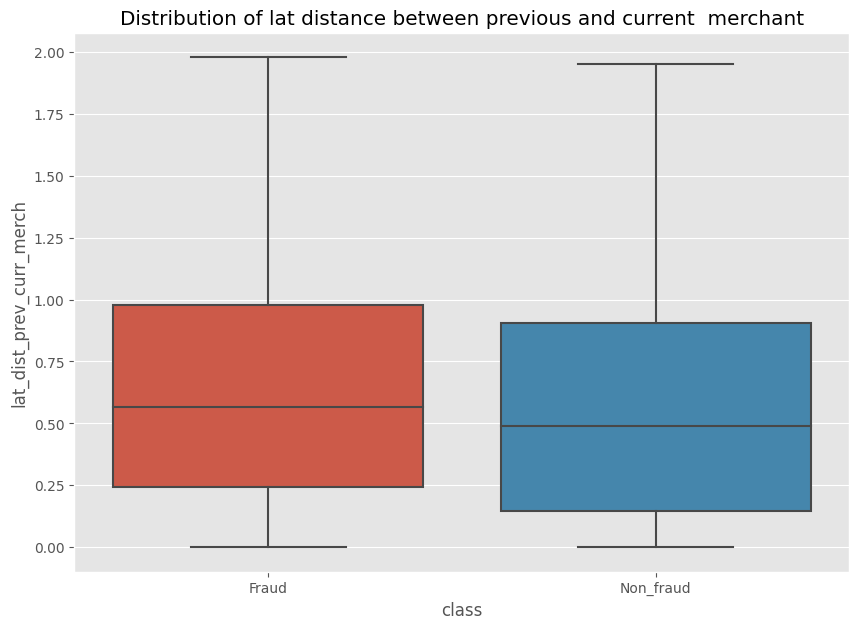

In [121]:
plot_box(total_transactions, 'class','lat_dist_prev_curr_merch','Distribution of lat distance between previous and current  merchant')

- Conclusion: No observable difference

# Long distance between previous and current merchant

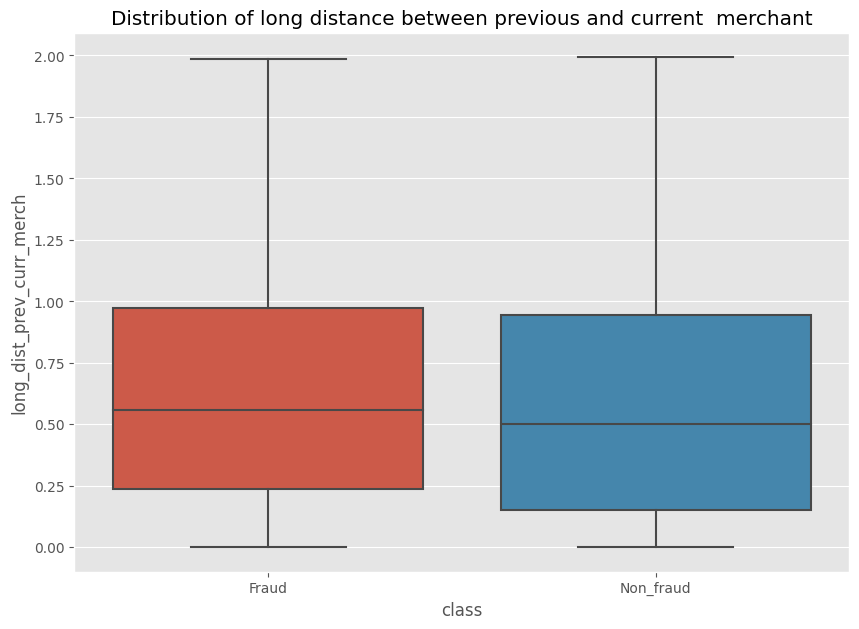

In [122]:
plot_box(total_transactions, 'class','long_dist_prev_curr_merch','Distribution of long distance between previous and current  merchant')

- Conclusion: No observable difference

# Category of Item / Service purchased


Normalized frequency of < category > on both classes and the % difference



,category,normal,fraud,diff in %
2,home,9.717138,2.583764,-7.133374
3,kids_pets,8.302829,3.083847,-5.218981
7,food_dining,6.888519,2.033672,-4.854847
9,health_fitness,6.539101,1.783631,-4.755471
6,personal_care,7.487521,2.900483,-4.587037
10,entertainment,6.439268,3.000500,-3.438768
8,misc_pos,6.705491,3.367228,-3.338263
0,gas_transport,10.066556,8.134689,-1.931867
12,grocery_net,3.610649,1.750292,-1.860357
13,travel,3.028286,1.550258,-1.478028


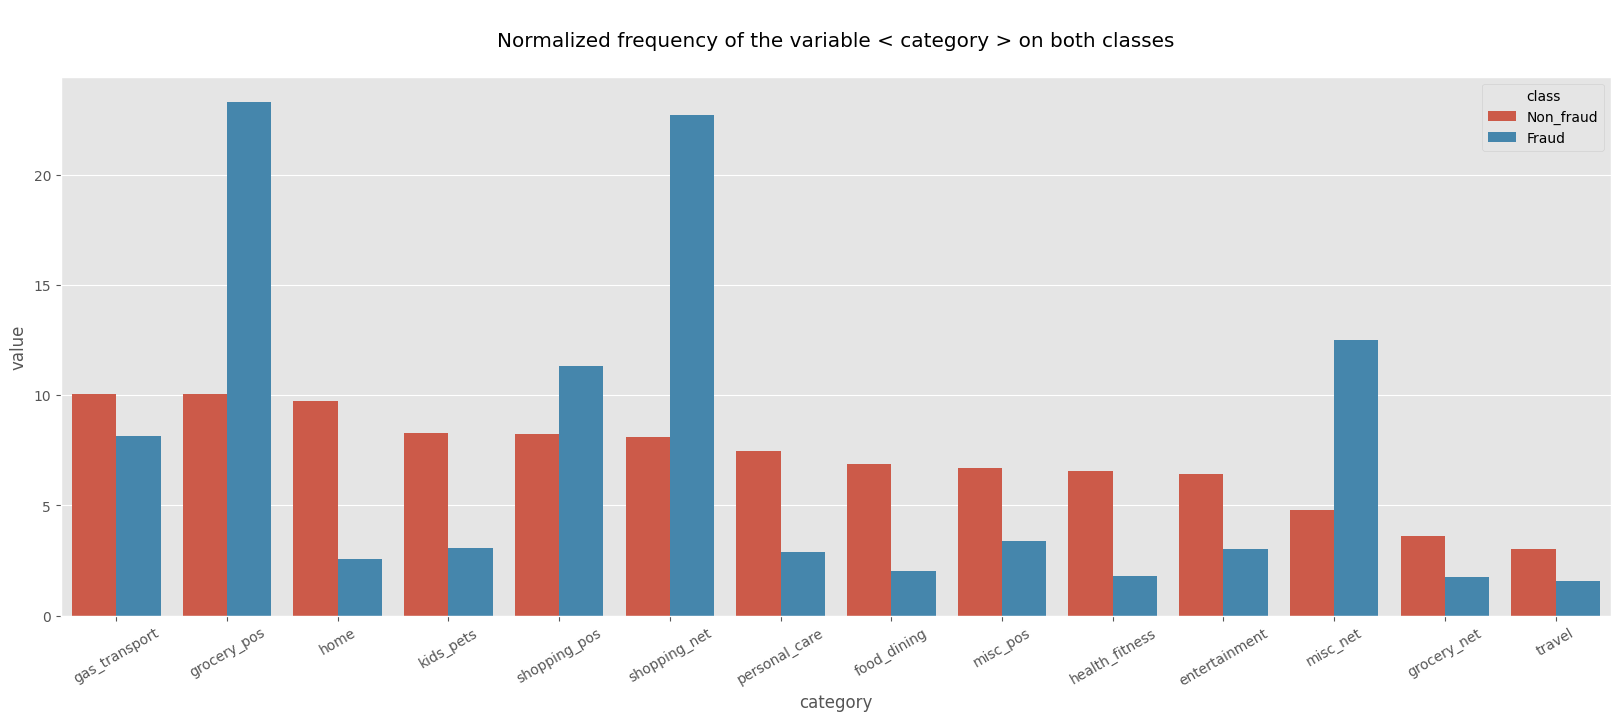

In [123]:
normalize_count_by_class('category')

- Conclusion: The normalized % of the grocery_pos, shopping_pos, shopping_net, misc_net are higher for fraud transactions

# State



Normalized frequency of < state > on both classes and the % difference



,state,normal,fraud,diff in %
0,tx,7.321131,6.217703,-1.103428
5,al,3.777038,2.917153,-0.859885
6,mi,3.727121,3.050508,-0.676613
37,mt,1.048253,0.450075,-0.598178
40,az,0.898502,0.450075,-0.448427
9,mo,2.995008,2.567095,-0.427914
43,ct,0.582363,0.216703,-0.365660
25,la,1.680532,1.333556,-0.346977
13,nc,2.229617,1.883647,-0.345970
44,id,0.465890,0.133356,-0.332535


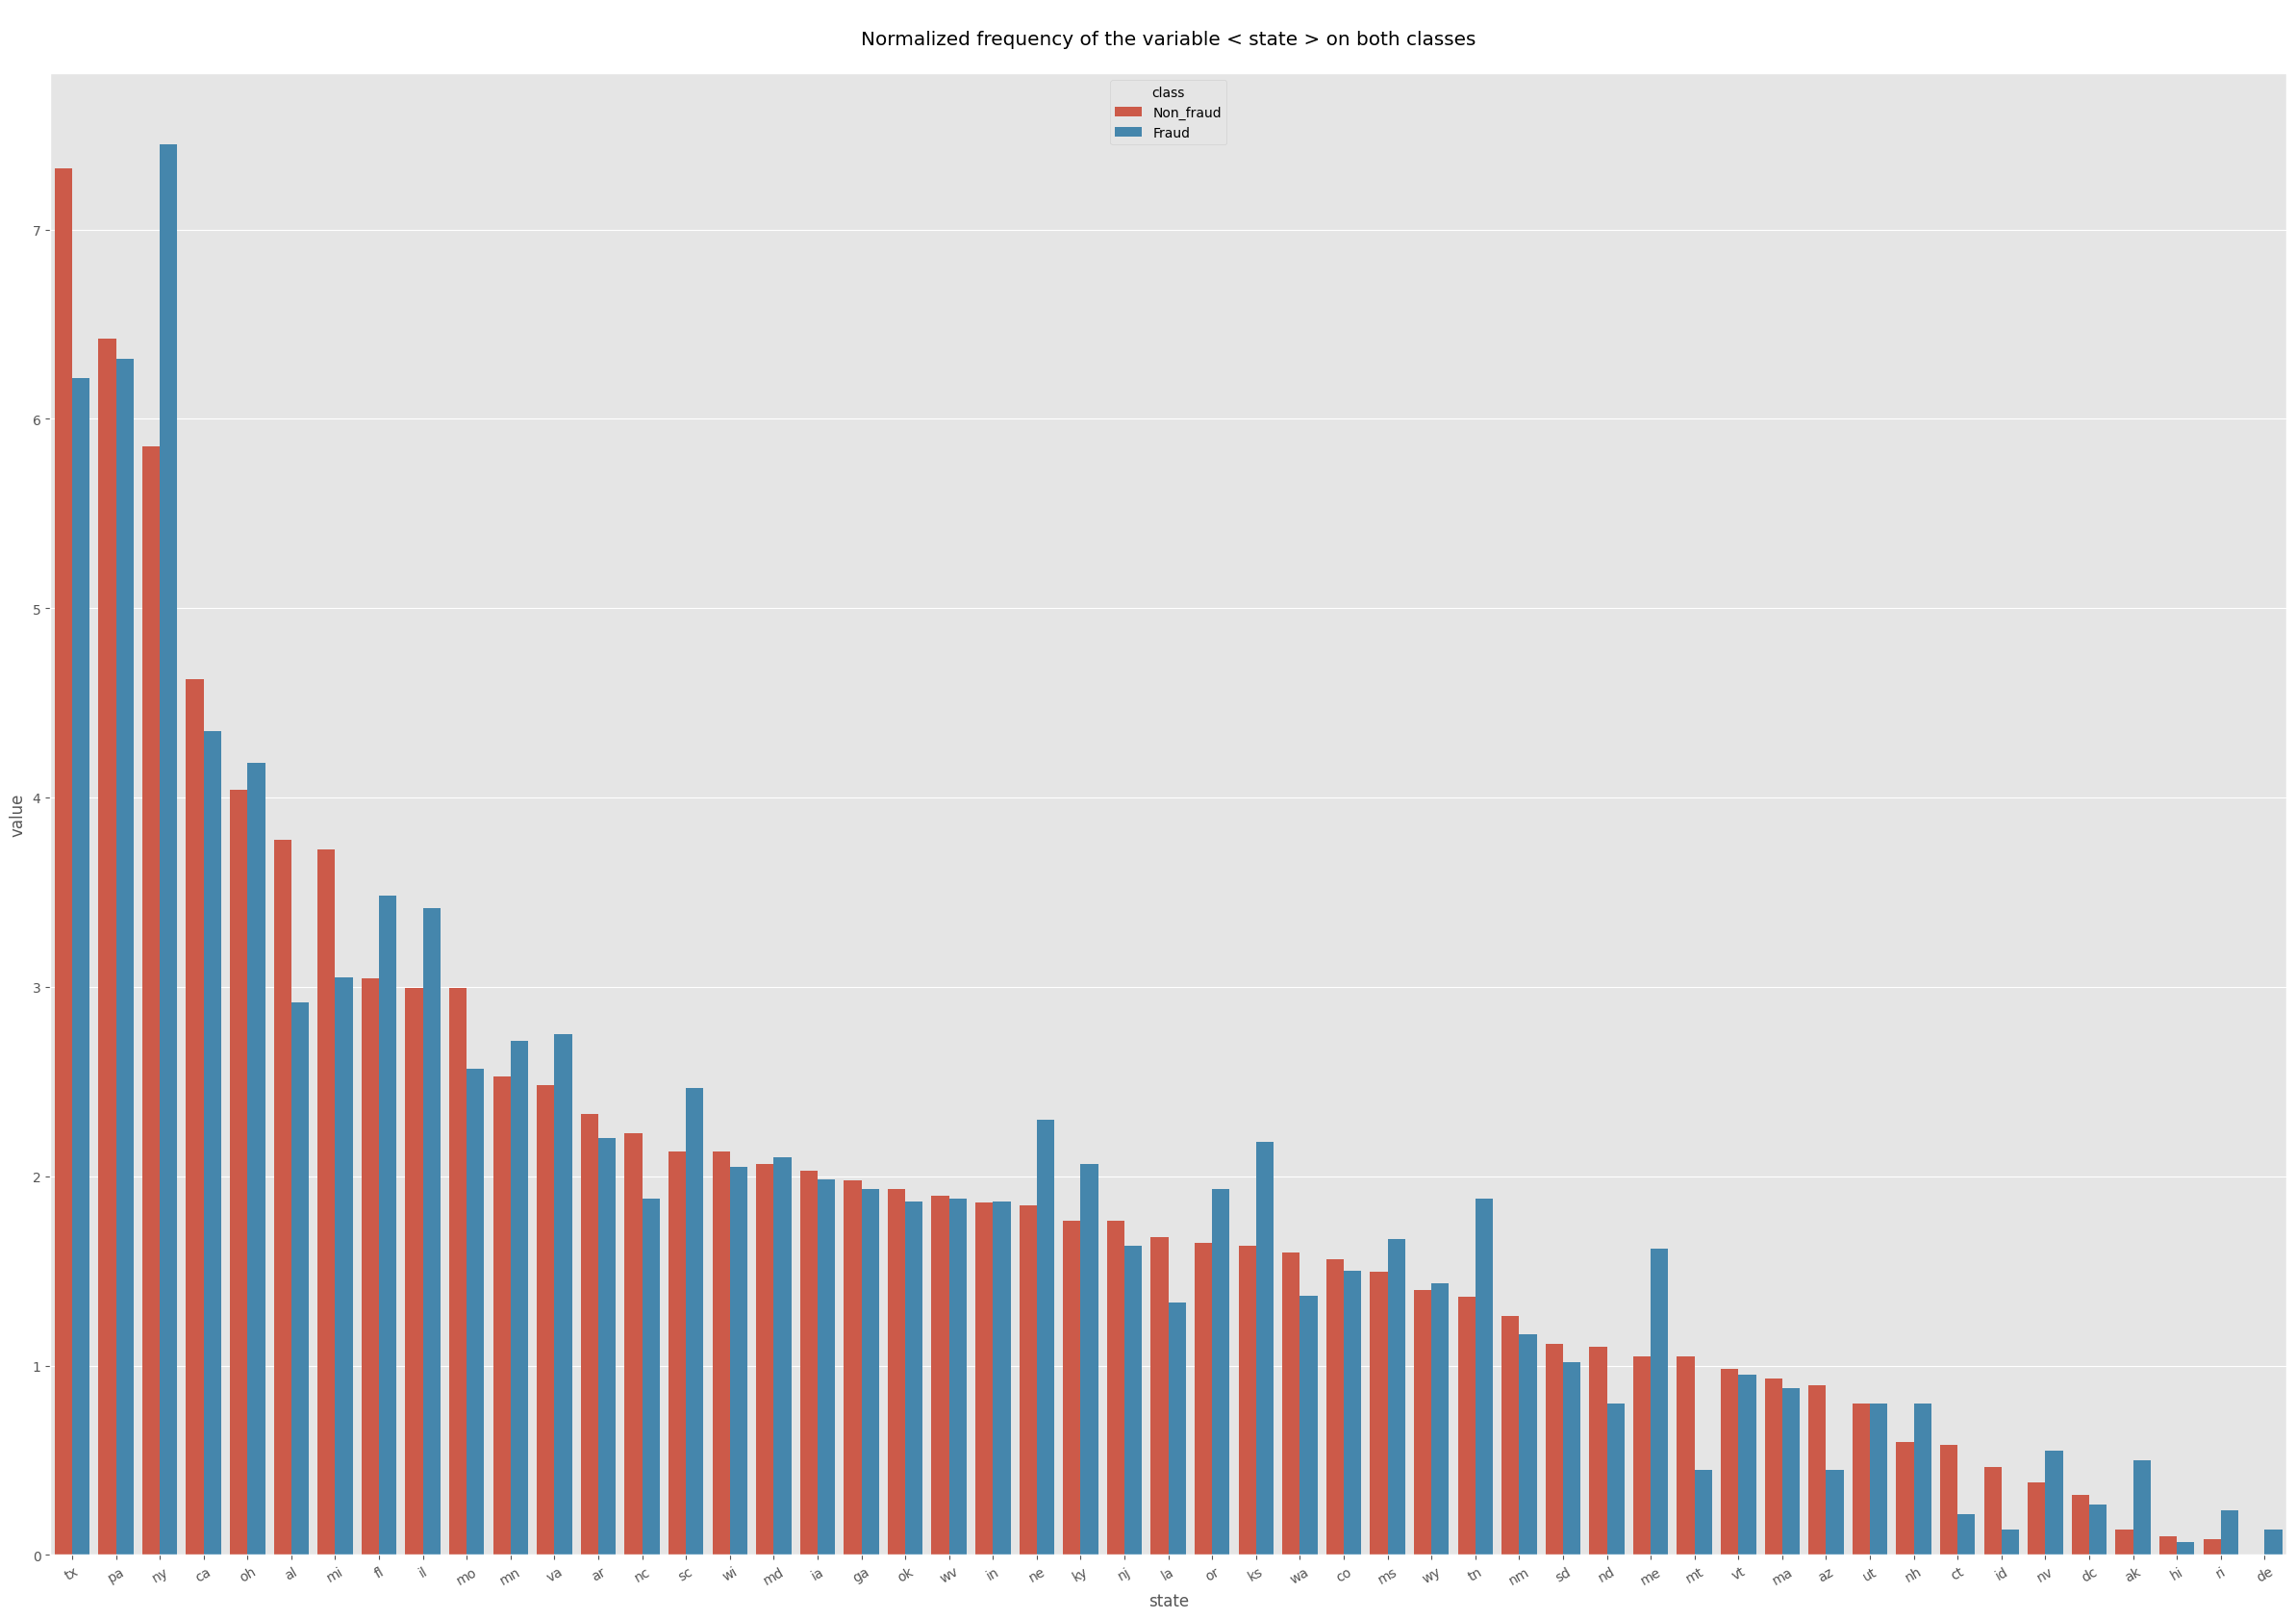

In [124]:
normalize_count_by_class('state', width = 30, height = 20)

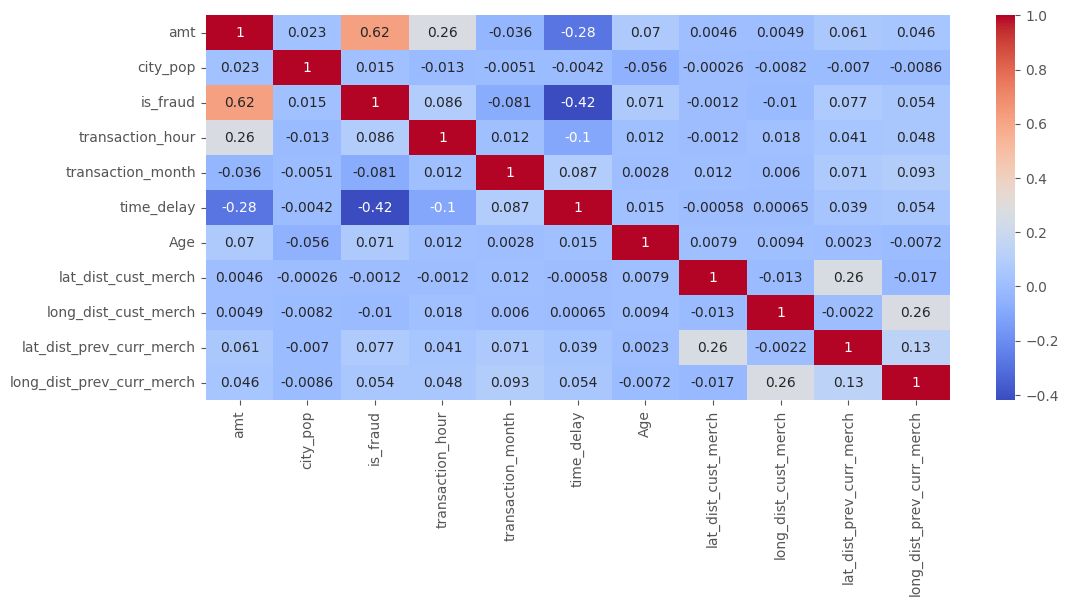

In [126]:
plt.figure(figsize = (12,5),dpi = 100)
sns.heatmap(total_transactions.corr(),cmap = 'coolwarm',annot = True )
plt.show()

 # Delete dataframes created for ploting purpose for free up the memory

In [127]:
del total_transactions,Normal,Fraud

# Splitting the data into training and test sets

In [150]:
cols = list(data.columns)
cols.remove('is_fraud')
cols

['category',
 'amt',
 'gender',
 'state',
 'city_pop',
 'transaction_hour',
 'transaction_month',
 'transaction_DayofWeek',
 'time_delay',
 'Age',
 'lat_dist_cust_merch',
 'long_dist_cust_merch',
 'lat_dist_prev_curr_merch',
 'long_dist_prev_curr_merch']

In [152]:
len(cols)

14

In [153]:
x = data[cols]
y = data['is_fraud']

In [154]:
cat_cols = x.select_dtypes(exclude = np.number).columns

print(cat_cols)

x[cat_cols].nunique().sort_values(ascending = False)

Index(['category', 'gender', 'state', 'transaction_DayofWeek'], dtype='object')


state                    51
category                 14
transaction_DayofWeek     7
gender                    2
dtype: int64

# Choose Encoding methods:
 
1. Target Guided Mean Encoding : 'state','transaction_DayofWeek','category',  'gender'

In [160]:
pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 6.7 MB/s eta 0:00:00


In [161]:
from feature_engine.encoding import MeanEncoder

In [162]:
variables = ['state','transaction_DayofWeek','category', 'gender']

In [163]:
mean_encoder  = MeanEncoder(variables = variables)

In [165]:
mean_encoder.fit(x,y)

MeanEncoder(variables=['state', 'transaction_DayofWeek', 'category', 'gender'])

In [166]:
x = mean_encoder.transform(x)

In [167]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [169]:
x_train.shape

(9607, 14)

# Neural Network

In [171]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [172]:
import tensorflow as tf

In [173]:
from tensorflow import keras

In [174]:
from keras import models
from keras import layers
from keras.layers.core import Dropout

In [183]:
model = keras.models.Sequential([
 keras.layers.Dense(units=100, input_shape=(14,), activation='sigmoid',kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.2),
 keras.layers.Dense(units=150, activation='sigmoid',kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.5),
 keras.layers.Dense(units=200, activation='sigmoid',kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.8),
 keras.layers.Dense(units=75, activation='sigmoid',kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.4),
 keras.layers.Dense(units=50, activation='sigmoid',kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.2),
 keras.layers.Dense(units=1, activation='sigmoid'),
 ])

In [184]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               1500      
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 150)               15150     
                                                                 
 dropout_6 (Dropout)         (None, 150)               0         
                                                                 
 dense_11 (Dense)            (None, 200)               30200     
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 75)               

In [185]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss='binary_crossentropy', metrics=['accuracy'])

In [186]:
history = model.fit(x_train, y_train,epochs=10,batch_size=500,validation_data=(x_test,y_test))

Epoch 1/10
20/20 [==============================] - 3s 46ms/step - loss: 0.7520 - accuracy: 0.5065 - val_loss: 0.7086 - val_accuracy: 0.5104
Epoch 2/10
20/20 [==============================] - 0s 19ms/step - loss: 0.7058 - accuracy: 0.5199 - val_loss: 0.6538 - val_accuracy: 0.7973
Epoch 3/10
20/20 [==============================] - 0s 19ms/step - loss: 0.6684 - accuracy: 0.5923 - val_loss: 0.5732 - val_accuracy: 0.7977
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 0.5792 - accuracy: 0.7204 - val_loss: 0.4726 - val_accuracy: 0.8035
Epoch 5/10
20/20 [==============================] - 0s 18ms/step - loss: 0.4941 - accuracy: 0.8045 - val_loss: 0.4564 - val_accuracy: 0.8201
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 0.4474 - accuracy: 0.8288 - val_loss: 0.4088 - val_accuracy: 0.8439
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.4075 - accuracy: 0.8514 - val_loss: 0.3668 - val_accuracy: 0.8684
Epoch 8/10
20

In [187]:
history.validation_data

In [189]:
model.evaluate(x_test,y_test)

76/76 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.8863


[0.3277016282081604, 0.8863447308540344]

In [202]:
y_predict = model.predict(x_test)

76/76 [==============================] - 0s 2ms/step


In [203]:
y_predict.shape

(2402, 1)

In [204]:
y_predict[0:5]

array([[0.94596267],
       [0.06526875],
       [0.06526875],
       [0.11632991],
       [0.06526875]], dtype=float32)

In [192]:
y_test[:5]

9257     1
6913     0
4720     0
7223     0
10172    0
Name: is_fraud, dtype: int64

In [206]:
def predict(x):
    y = model.predict(x)
    for i in range(len(x)):
        if y[i] > 0.5:
            y[i] = 1
        else:
            y[i] = 0
    return y


In [208]:
y_predict = predict(x_test)

76/76 [==============================] - 0s 2ms/step


In [216]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score,recall_score,f1_score

In [210]:
accuracy = accuracy_score(y_test,y_predict)
print('The Accuracy is ',accuracy)

The Accuracy is  0.8863447127393839


In [211]:
precision = precision_score(y_test,y_predict)
print('The Precision is ',precision)

The Precision is  0.9296663660955816


In [212]:
recall = recall_score(y_test,y_predict)
print('The Recall is ',recall)

The Recall is  0.8409461663947798


In [214]:
f1_score = f1_score(y_test,y_predict)
print('The F1_score is ',f1_score)

The F1_score is  0.883083511777302


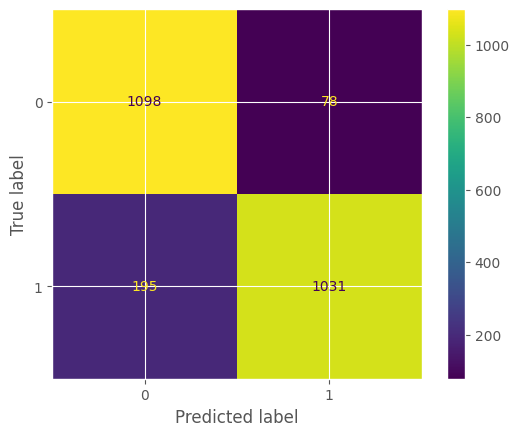

In [217]:
cm = confusion_matrix(y_test, y_predict)
ConfusionMatrixDisplay(cm).plot()